In [1]:
# load and summarize the housing dataset
import numpy as np
import pandas as pd
import warnings
import random
import seaborn as sns 

random.seed(7)

from utils import *
from AutoEncoder_models import *
from DeepSurv_models import *

from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import ElasticNet, LinearRegression
from sksurv.linear_model import CoxnetSurvivalAnalysis as CoxPH
from sksurv.metrics import concordance_index_censored
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.exceptions import FitFailedWarning
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from functools import reduce
from lifelines import CoxPHFitter
from statsmodels.api import OLS, add_constant

set2_proteins = pd.read_csv('Data/Processed/Full/full_val.csv', index_col = 'eid')
# summarize shape
# print(set2_proteins.shape) #1428 proteins
# summarize first few lines
# print(set2_proteins.head())

#Age 
age = pd.read_csv('./Data/basicinfo.csv', low_memory=False, index_col = 'eid') #age
age = age[['age_center.0.0']]
age = age.rename(columns={'age_center.0.0': 'age'})

#Mortality
set2_mort = pd.read_csv("Data/Processed/Full/mort_full_test.csv", index_col = 'eid') #differently named, chosen based on number of individuals

#Frailty
frailty_set2 = pd.read_csv('Data/frailty_clean_set2.csv', index_col = 'eid')

/tmp/ipykernel_1570093/1877537923.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Inladen data

In [2]:
#Extract eids as there was a minor error in code to create scores
_, _, eids_train_frailty_full, eids_set2_frailty_full, _ = get_data({'dset': 'cmb', 'target': 'frailty'})
_, _, eids_train_mort_full, eids_set2_mort_full, _ = get_data({'dset': 'cmb', 'target': 'mort'})
_, _, eids_train_frailty, eids_set2_frailty, _ = get_data({'dset': 'cmb_met', 'target': 'frailty'})
_, _, eids_train_mort, eids_set2_mort, _ = get_data({'dset': 'cmb_met', 'target': 'mort'})

In [3]:
len(eids_set2_mort)

4321

In [3]:
# Function to remove repetiveness
def load_data(file_path, index):
    return pd.read_csv(file_path).drop(columns=["Unnamed: 0"]).set_index(index)

# File paths and indices for mortality scores; still need allprot and ffs and clusters
mort_files = {
    "en_pred_cmb_mort": ('output_linear/set2mort/en_mort_cmb_set2.csv', eids_set2_mort_full),
    "en_pred_cmb_metset_mort": ('output_linear/set2mort/en_mort_cmb_sub_set2.csv', eids_set2_mort),
    "en_pred_cmb_met_mort": ('output_linear/set2mort/en_mort_cmb_met_set2.csv', eids_set2_mort),
    "en_pred_cmb_pca10_mort": ('output_linear/set2mort/en_mort_cmb_met_pca_set2.csv', eids_set2_mort),
    "en_pred_cmb_pca20_mort": ('output_linear/set2mort/en_mort_cmb_met_pca20_set2.csv', eids_set2_mort),
    "en_pred_cmb_ajive10_mort": ('output_linear/set2mort/en_mort_cmb_met_ajive10_set2.csv', eids_set2_mort),
    #"en_pred_cmb_met_cluster_mort" : ('output_linear/set2mort/en_cluster_200_mort_cmb_met_set2.csv', eids_set2_mort),
    "en_pred_8_always_mort": ('output_linear/set2mort/en_mort_alwaysinbootstrap_set2.csv', eids_set2_mort),
    "en_pred_allprot_ffs_mort": ('output_linear/set2mort/en_mort_allprot_ffs_set2.csv', eids_set2_mort_full),
    "en_pred_cmb_ffs_mort" : ('output_linear/set2mort/en_mort_cmb_ffs_set2.csv', eids_set2_mort_full),
    "en_pred_cmb_met_ffs_mort" : ('output_linear/set2mort/en_mort_cmb_met_ffs_set2.csv', eids_set2_mort),
   # "en_pred_cmb_met_cluster_mort" : ("output_linear/set2mort/", eids_set2_mort),
    "en_pred_cmb_mh_mort": ('output_linear/set2mort/en_mort_cmb_mh_set2.csv', eids_set2_mort),
    "en_pred_gdf15_mh_mort":('output_linear/set2mort/en_mort_MH_GDF15_set2.csv', eids_set2_mort)
}

# File paths and indices for frailty scores;
frailty_files = {
    "en_pred_allprot_frailty": ('output_linear/set2frail/en_frailty_allprot_set2.csv', eids_set2_frailty_full),
    "en_pred_cmb_frailty": ('output_linear/set2frail/en_frailty_cmb_set2.csv', eids_set2_frailty_full),
    "en_pred_cmb_metset_frailty": ('output_linear/set2frail/en_frailty_cmb_sub_set2.csv', eids_set2_frailty),
    "en_pred_cmb_met_frailty": ('output_linear/set2frail/en_frailty_cmb_met_set2.csv', eids_set2_frailty),
    "en_pred_cmb_pca_frailty": ('output_linear/set2frail/en_frailty_cmb_met_pca_set2.csv', eids_set2_frailty),
    "en_pred_cmb_pca20_frailty": ('output_linear/set2frail/en_frailty_cmb_met_pca20_set2.csv', eids_set2_frailty),
    "en_pred_cmb_ajive10_frailty": ('output_linear/set2frail/en_frailty_cmb_met_ajive10_set2.csv', eids_set2_frailty),
    "en_pred_cmb_met_cluster_frailty" : ('output_linear/set2frail/en_cluster_200_frailty_cmb_met_set2.csv', eids_set2_frailty),
    "en_pred_41_always_frailty": ('output_linear/set2frail/en_alwaysinbootstrap_set2.csv', eids_set2_frailty),
    "en_ffs_allprot_frailty": ('output_linear/set2frail/en_frailty_allprot_ffs_set2.csv', eids_set2_frailty_full),
    "en_ffs_cmb_frailty": ('output_linear/set2frail/en_frailty_cmb_ffs_set2.csv', eids_set2_frailty_full),
    "en_ffs_cmb_met_frailty": ('output_linear/set2frail/en_frailty_cmb_met_ffs_set2.csv', eids_set2_frailty),
    "en_pred_cmb_mh_frailty": ('output_linear/set2frail/en_frailty_cmb_mh_set2.csv', eids_set2_frailty),
    "en_pred_gdf15_mh_frailty": ('output_linear/set2frail/en_GDF15_MH_set2.csv', eids_set2_frailty),
}

# Loading mortality and frailty datasets
mortality_dfs = {name: load_data(path, idx) for name, (path, idx) in mort_files.items()}
frailty_dfs = {name: load_data(path, idx) for name, (path, idx) in frailty_files.items()}

In [4]:
def load_data(file_path, index, name):
    df = pd.read_csv(file_path).drop(columns=["Unnamed: 0"])
    print(f"{name} - DataFrame rows: {len(df)}, Index length: {len(index)}")
    return df.set_index(index)

# Loading mortality datasets with debug prints
mortality_dfs = {}
for name, (path, idx) in mort_files.items():
    try:
        mortality_dfs[name] = load_data(path, idx, name)
    except ValueError as e:
        print(f"Error for {name}: {e}")

# Loading frailty datasets with debug prints
frailty_dfs = {}
for name, (path, idx) in frailty_files.items():
    try:
        frailty_dfs[name] = load_data(path, idx, name)
    except ValueError as e:
        print(f"Error for {name}: {e}")


en_pred_cmb_mort - DataFrame rows: 8138, Index length: 8138
en_pred_cmb_metset_mort - DataFrame rows: 4321, Index length: 4321
en_pred_cmb_met_mort - DataFrame rows: 4321, Index length: 4321
en_pred_cmb_pca10_mort - DataFrame rows: 4321, Index length: 4321
en_pred_cmb_pca20_mort - DataFrame rows: 4321, Index length: 4321
en_pred_cmb_ajive10_mort - DataFrame rows: 4321, Index length: 4321
en_pred_8_always_mort - DataFrame rows: 4321, Index length: 4321
en_pred_allprot_ffs_mort - DataFrame rows: 8138, Index length: 8138
en_pred_cmb_ffs_mort - DataFrame rows: 8138, Index length: 8138
en_pred_cmb_met_ffs_mort - DataFrame rows: 4321, Index length: 4321
en_pred_cmb_mh_mort - DataFrame rows: 4321, Index length: 4321
en_pred_gdf15_mh_mort - DataFrame rows: 4321, Index length: 4321
en_pred_allprot_frailty - DataFrame rows: 8137, Index length: 8137
en_pred_cmb_frailty - DataFrame rows: 8137, Index length: 8137
en_pred_cmb_metset_frailty - DataFrame rows: 4320, Index length: 4320
en_pred_cmb_met_

In [5]:
# Merge mortality and frailty datasets then combine
en_pred_cmb_mortality = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True), mortality_dfs.values())
en_pred_cmb_frailty = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True), frailty_dfs.values())
en_combined_data = pd.merge(en_pred_cmb_mortality, en_pred_cmb_frailty, left_index=True, right_index=True)

In [6]:
en_combined_data

en_mort_cmb  en_mort_cmb_sub  en_mort_cmb_met  en_mort_cmb_met_pca  \
4523051.0    -1.454485        -1.473683        -1.411170            -0.077860   
4533555.0     0.277077         0.493338         0.316635             0.101200   
4536185.0     0.103772         0.071769         0.145304            -0.529814   
4545374.0    -1.282478        -1.324727        -1.202487            -0.568815   
4545590.0     0.188728         0.116117         0.164645            -0.099236   
...                ...              ...              ...                  ...   
5362681.0     0.543943         0.497907         0.513494            -0.034927   
3185780.0    -0.700218        -0.974597        -1.162405            -1.203485   
2300683.0     0.272935         0.309871         0.129573            -0.371574   
2009886.0     1.917680         1.431834         1.489895             1.239859   
5478192.0    -0.080081        -0.409601        -0.425676             0.047011   

           en_mort_cmb_met_pca20  en_mort_cmb_met_ajive10  en_boot_mort  \
4523051.0              -0.654124                -0.142327     -0.571664   
4533555.0               0.373463                -0.094387      0.519160   
4536185.0               0.125342                -0.843444     -0.307028   
4545374.0              -0.561922                 0.024393     -0.696838   
4545590.0               0.220547                -0.087829      0.253661   
...                          ...                      ...           ...   
5362681.0               0.191805                -0.465645      0.320163   
3185780.0              -0.930443                -1.035106     -0.469781   
2300683.0              -0.177527                -0.759144     -0.481468   
2009886.0               1.362062                 0.701797      1.349943   
5478192.0              -0.199611                 0.194528      0.263038   

           en_mort_allprot_ffs  en_mort_cmb_ffs  en_mort_cmb_met_ffs  ...  \
4523051.0            -0.408508        -0.235590            -0.354538  ...   
4533555.0            -0.041965        -0.022389             0.060651  ...   
4536185.0            -0.575933        -0.859223            -0.798555  ...   
4545374.0            -0.477448        -0.295342            -0.174831  ...   
4545590.0             0.257272         0.342205             0.209113  ...   
...                        ...              ...                  ...  ...   
5362681.0            -0.068100        -0.510943            -0.234549  ...   
3185780.0            -0.587857        -0.559128            -1.243241  ...   
2300683.0            -0.402805        -0.445016            -0.503869  ...   
2009886.0             0.595138        -0.177516             0.333386  ...   
5478192.0             0.117123        -0.234532            -0.274098  ...   

           en_frailty_cmb_met_pca  en_frailty_cmb_met_pca20  \
4523051.0                0.129450                  0.124073   
4533555.0                0.169853                  0.158209   
4536185.0                0.098803                  0.100253   
4545374.0                0.109659                  0.119192   
4545590.0                0.141109                  0.138611   
...                           ...                       ...   
5362681.0                0.110234                  0.117804   
3185780.0                0.070222                  0.073520   
2300683.0                0.112826                  0.112103   
2009886.0                0.145991                  0.147568   
5478192.0                0.114052                  0.095126   

           en_frailty_cmb_met_ajive10  en_cluster_200_frailty_cmb_met  \
4523051.0                    0.127781                        0.108854   
4533555.0                    0.170308                        0.170415   
4536185.0                    0.099661                        0.093320   
4545374.0                    0.102974                        0.108878   
4545590.0                    0.140463                        0.148537   
...              

In [13]:
# Get set and give column right name for joining
def assign_nn_pred(prefix, dataset, target, model_path):
    var_name = f'nn_pred_{prefix}_{target}'
    target2 = 'mort' if prefix == 'allprot' else target
    df = get_pred(prefix, dataset, target2, model_path)
    df.columns = [f'nn_{prefix}_{target}']
    globals()[var_name] = df

# Assign Neural Net scores for mortality
assign_nn_pred('allprot', 'ds_default', 'mort', "nn_models/model_sgncgwwy.pt")
assign_nn_pred('cmb', 'ds_default', 'mort', "nn_models/model_6csmrepn.pt")
assign_nn_pred('cmb_sub', 'ds_default', 'mort', "nn_models/model_ywtoc35b.pt")
assign_nn_pred('cmb_met', 'ds_default', 'mort', "nn_models/2024-09-19_model_ds_default_dset_cmb_met_target_mort.pt")
#assign_nn_pred('cmb_met_pca', 'ds_default', 'mort', "nn_models/2024-09-19_model_ds_default_dset_cmb_met_pca_target_mort.pt")
assign_nn_pred('cmb_mh', 'ds_default', 'mort', "nn_models/2024-09-19_model_ds_default_dset_cmb_mh_target_mort.pt")
#assign_nn_pred("cmb_met_pca20", "ds_default", "mort", "nn_models/model_fbcew9aw.pt")
#assign_nn_pred("cmb_met_ajive", "ds_default", "mort", "nn_models/model_12fhh6ej.pt")
#assign_nn_pred("cmb_4050", "ds_default", "mort",  "nn_models/model_gqbzl14e.pt")
#assign_nn_pred("cmb_5060", "ds_default", "mort", "nn_models/model_nkd6078j.pt")
#assign_nn_pred("cmb_6070", "ds_default", "mort", "nn_models/model_7m987sgf.pt")
#assign_nn_pred("cmb_clust", "ds_default", "mort", "nn_models/model_bl7ca64r.pt")
# assign_nn_pred("cmb_ffs", "ds_default", "mortality", "nn_models/model_juyzc25p.pt")
# assign_nn_pred("cmb_met_ffs", "ds_default", "mortality", "nn_models/model_g8mbi5fw.pt")
# assign_nn_pred("allprot_ffs", "ds_default", "mortality", 
#  still need,  FFS (3x) cluster bootstrap; filepaths probably need updates

# Assign Neural Net scores for frailty
#assign_nn_pred('allprot', 'ds_default', 'frailty', "nn_models/2024-07-02_model_ds_default_dset_allprot_target_frailty.pt")
# assign_nn_pred('cmb', 'ds_default', 'frailty', "nn_models/model_b3j66z7l.pt")
assign_nn_pred('cmb_met', 'ds_default', 'frailty', "nn_models/2024-09-19_model_ds_default_dset_cmb_met_target_frailty.pt")
assign_nn_pred('cmb_mh', 'ds_default', 'frailty', "nn_models/2024-09-19_model_ds_default_dset_cmb_mh_target_frailty.pt")
#assign_nn_pred("cmb_met_pca20", "ds_default", "frailty", "nn_models/model_g1kr439i.pt")
assign_nn_pred("cmb_met_ajive", "ds_default", "frailty", "nn_models/model_nh330vv6.pt")
# assign_nn_pred("cmb_sub", "ds_default", "frailty", "nn_models/model_51i91k36.pt")
#assign_nn_pred("cmb_met_pca", "ds_default", "frailty", "nn_models/model_diba1i9o.pt")
#assign_nn_pred("cmb_4050", "ds_default", "frailty", "nn_models/model_plqwcgvw.pt")
#assign_nn_pred("cmb_5060", "ds_default", "frailty", "nn_models/model_l9qgtjc9.pt")
#assign_nn_pred("cmb_6070", "ds_default","frailty", "nn_models/model_xsgcx9ks.pt")
#assign_nn_pred("cmb_clust", "ds_default", "frailty", "nn_models/model_rnyb9ort.pt")
assign_nn_pred("cmb_ffs", "ds_default", "frailty", "nn_models/model_7ntd8x28.pt")
assign_nn_pred("cmb_met_ffs", "ds_default", "frailty", "nn_models/model_taitkih4.pt")
assign_nn_pred("allprot_ffs", "ds_default", "frailty", "nn_models/model_raabjto7.pt") 
# still need cmb; filepaths probably need updates

KeyboardInterrupt: 

In [14]:
import pandas as pd

# Initialize an empty list to hold the DataFrames
dfs = []

# Append all the DataFrames created by assign_nn_pred to the list
dfs.append(nn_pred_allprot_mort)
dfs.append(nn_pred_cmb_mort)
# dfs.append(nn_pred_cmb_sub_mort)
# dfs.append(nn_pred_cmb_met_mort)
# dfs.append(nn_pred_cmb_met_pca_mort)
# dfs.append(nn_pred_cmb_mh_mort)
# dfs.append(nn_pred_cmb_met_pca20_mort)
# dfs.append(nn_pred_cmb_met_ajive_mort)
# #dfs.append(nn_pred_cmb_4050_mort)
# #dfs.append(nn_pred_cmb_5060_mort)
# #dfs.append(nn_pred_cmb_6070_mort)
# dfs.append(nn_pred_cmb_clust_mort)
# dfs.append(nn_pred_cmb_met_frailty)
# dfs.append(nn_pred_cmb_mh_frailty)
# dfs.append(nn_pred_cmb_met_pca20_frailty)
# dfs.append(nn_pred_cmb_met_ajive_frailty)
# dfs.append(nn_pred_cmb_met_pca_frailty)
# #dfs.append(nn_pred_cmb_4050_frailty)
# #dfs.append(nn_pred_cmb_5060_frailty)
# #dfs.append(nn_pred_cmb_6070_frailty)
# dfs.append(nn_pred_cmb_clust_frailty)
# dfs.append(nn_pred_cmb_ffs_frailty)
# dfs.append(nn_pred_cmb_met_ffs_frailty)
# dfs.append(nn_pred_allprot_ffs_frailty)

# Merge all DataFrames on the index
merged_df = dfs[0]
for df in dfs[1:]:
    merged_df = merged_df.merge(df, left_index=True, right_index=True, how='outer')

# Now merged_df contains all the predictions merged on index


In [15]:
merged_df

nn_allprot_mort  nn_cmb_mort
1002377        -0.245156     0.054323
1004582         0.874598     0.895349
1004611         0.039902    -0.065819
1006947         0.329305     0.304887
1011233        -0.296565    -0.063609
...                  ...          ...
6017667        -0.105278     0.148839
6020111        -0.181395    -0.030025
6021911         0.115194     0.417295
6023987         0.763328     0.731031
6024261         2.067983     3.081238

[8138 rows x 2 columns]

In [16]:
# Merge mortality and frailty datasets then combine
nn_pred_cmb_mortality = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True), 
                               [v for k, v in globals().items() if k.startswith('nn_') and k.endswith('_mort')])
nn_pred_cmb_frailty = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True), 
                             [v for k, v in globals().items() if k.startswith('nn_') and k.endswith('_frailty')])
nn_combined_data = pd.merge(nn_pred_cmb_mortality, nn_pred_cmb_frailty, left_index=True, right_index=True)

#now combine with elastic net results
#biomarkers = pd.merge(en_combined_data, nn_combined_data, left_index=True, right_index=True)

In [17]:
biomarkers = pd.merge(en_combined_data, merged_df, left_index=True, right_index=True)


In [18]:
frailty_set2.head()

FI_0
eid              
4516850  0.222449
4517099  0.010204
4517165  0.173469
4517441  0.306122
4517585  0.134694

In [19]:
biomarkers.columns

Index(['en_mort_cmb', 'en_mort_cmb_sub', 'en_mort_cmb_met',
       'en_mort_cmb_met_pca', 'en_mort_cmb_met_pca20',
       'en_mort_cmb_met_ajive10', 'en_boot_mort', 'en_mort_allprot_ffs',
       'en_mort_cmb_ffs', 'en_mort_cmb_met_ffs', 'en_mort_cmb_mh',
       'en_GDF15_MH_mort', 'en_frailty_allprot', 'en_frailty_cmb',
       'en_frailty_cmb_sub', 'en_frailty_cmb_met', 'en_frailty_cmb_met_pca',
       'en_frailty_cmb_met_pca20', 'en_frailty_cmb_met_ajive10',
       'en_cluster_200_frailty_cmb_met', 'en_bootcols',
       'en_frailty_allprot_ffs', 'en_frailty_cmb_ffs',
       'en_frailty_cmb_met_ffs', 'en_frailty_cmb_mh', 'en_GDF15_MH_frail',
       'nn_allprot_mort', 'nn_cmb_mort'],
      dtype='object')

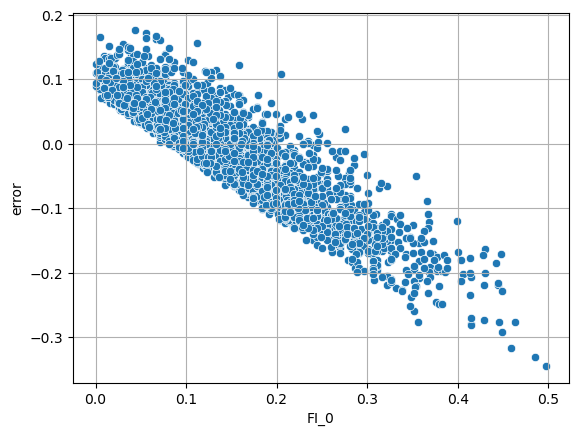

In [29]:
import seaborn as sns
marker_name = "nn_cmb_ffs_frailty"
marker_df = biomarkers[marker_name]

full_df = pd.merge(marker_df, frailty_set2, left_index = True, right_index = True)
full_df['error'] = full_df[marker_name] - full_df[frailty_set2.columns[0]]
sns.scatterplot(data = full_df, y = 'error', x="FI_0")
plt.grid()

In [22]:
full_df.head()

nn_cmb_ffs_frailty      FI_0     error
4523051.0            0.098919  0.081633  0.017286
4533555.0            0.165786  0.117347  0.048439
4536185.0            0.092068  0.181633 -0.089565
4545374.0            0.099714  0.109184 -0.009470
4545590.0            0.156834  0.224490 -0.067656

In [93]:
def plot_on_endpoints(score_df, marker_name, endpoint_df, sort_on_df, show_figure = True):
    marker_df = score_df[marker_name]
    endpoint_name = endpoint_df.columns[0]
    sort_name = sort_on_df.columns[0]
    
    full_df = pd.merge(marker_df, endpoint_df, left_index = True, right_index = True)
    if endpoint_df is not sort_on_df:
        full_df = pd.merge(full_df, sort_on_df, left_index = True, right_index = True)
    full_df['error'] = full_df[endpoint_name]- full_df[marker_name]

    LR = LinearRegression()
    LR.fit(full_df[sort_name].values.reshape(-1, 1), full_df['error'].values)
    

    if show_figure:
        sns.scatterplot(data = full_df, y ='error', x=sort_name)
        axes = plt.gca()
        x_vals = np.array(axes.get_xlim())
        y_vals = LR.coef_ * x_vals + LR.intercept_
        plt.plot(x_vals, y_vals, color = "red")
        plt.title(f'coef: {LR.coef_}')
        plt.grid()
    return LR.coef_,

In [130]:
def get_mse_mostfrail(mostfrail_eids, biomarkers, marker_name):
    marker = biomarkers[marker_name]
    marker_mostfrail = marker.loc[marker.index.isin(mostfrail_eids)]
    frailty_mostfrail = frailty_set2.loc[frailty_set2.index.isin(marker_mostfrail.index)]
    frailty_mostfrail = frailty_mostfrail.reindex(marker_mostfrail.index)
    mse = np.mean((marker_mostfrail.values - frailty_mostfrail['FI_0'].values)**2)
    return mse

In [135]:
mses = {}
for marker in biomarkers.columns:
    if 'mort' in marker:
        continue
    mse = get_mse_mostfrail(mostfrail_eids, biomarkers, marker)
    mses[marker] = mse

In [136]:
mses

{'en_frailty_allprot': 0.04823252701016246,
 'en_frailty_cmb': 0.05506419754777874,
 'en_frailty_cmb_sub': 0.055987141190387654,
 'en_frailty_cmb_met': 0.05358032381062117,
 'en_frailty_cmb_met_pca': 0.06213048618622833,
 'en_frailty_cmb_met_pca20': 0.06011529493240672,
 'en_frailty_cmb_met_ajive10': 0.06258468542407206,
 'en_cluster_200_frailty_cmb_met': 0.05892842932681007,
 'en_bootcols': 0.05951559821121086,
 'en_frailty_allprot_ffs': 0.055815704839554045,
 'en_frailty_cmb_ffs': 0.06090923361906993,
 'en_frailty_cmb_met_ffs': 0.05692578871367845,
 'en_frailty_cmb_mh': 0.05532050791179999,
 'en_GDF15_MH_frail': 0.07136321473475328,
 'nn_cmb_met_frailty': 0.0639143761125638,
 'nn_cmb_mh_frailty': 0.05985064515709954,
 'nn_cmb_met_pca20_frailty': 0.06841290491350425,
 'nn_cmb_met_ajive_frailty': 0.20999329834371816,
 'nn_cmb_met_pca_frailty': 0.29141083943140156,
 'nn_cmb_clust_frailty': 0.06009311274276137,
 'nn_cmb_ffs_frailty': 0.058204204347031406,
 'nn_cmb_met_ffs_frailty': 0.054

In [131]:
get_mse_mostfrail(mostfrail_eids, biomarkers, "nn_cmb_ffs_frailty")

0.058204204347031406

In [112]:
mostfrail_eids = mostfrail_eids.astype(float)

In [118]:
len(mostfrail_eids)

49

In [111]:
marker

4523051.0    0.098919
4533555.0    0.165786
4536185.0    0.092068
4545374.0    0.099714
4545590.0    0.156834
               ...   
5362681.0    0.118807
3185780.0    0.130784
2300683.0    0.117405
2009886.0    0.135778
5478192.0    0.112482
Name: nn_cmb_ffs_frailty, Length: 4320, dtype: float64

In [127]:
marker = biomarkers["nn_cmb_ffs_frailty"]
marker_mostfrail = marker.loc[marker.index.isin(mostfrail_eids)]
frailty_mostfrail = frailty_set2.loc[frailty_set2.index.isin(marker_mostfrail.index)]
frailty_mostfrail = frailty_mostfrail.reindex(marker_mostfrail.index)
mse = np.mean((marker_mostfrail.values - frailty_mostfrail['FI_0'].values)**2)

In [128]:
mse

0.058204204347031406

In [119]:
marker_mostfrail.head()

1721011.0    0.204868
5055264.0    0.225219
5990788.0    0.267153
4190740.0    0.208795
2098021.0    0.186702
Name: nn_cmb_ffs_frailty, dtype: float64

In [94]:
coefs_age = {}
for marker in biomarkers.columns:
    if 'mort' in marker:
        continue
    coef = plot_on_endpoints(biomarkers, marker, frailty_set2, age, show_figure = False)
    coefs_age[marker] = coef

In [101]:
mostfrail_eids = pd.read_csv("Data/mostfrail_set2.csv", index_col = "eid").index

In [102]:
mostfrail_eids

Index([4519482, 4552426, 4562446, 4585198, 4684694, 4699949, 4708217, 4789577,
       4845853, 4867222, 4919197, 4949208, 5089997, 5115585, 5159922, 5242260,
       5266377, 5330056, 5344330, 5370710, 5381162, 5479279, 1721011, 5055264,
       5990788, 4190740, 2098021, 1370174, 1334408, 1926542, 5476858, 3651161,
       2761478, 5163942, 3711070, 1535245, 4757792, 4490091, 3151977, 3713978,
       1986945, 3860007, 3469620, 4587647, 4702102, 5389660, 2022322, 2904918,
       2182069],
      dtype='int64', name='eid')

In [63]:
coefs

{'en_frailty_allprot': array([0.73244957]),
 'en_frailty_cmb': array([0.77066747]),
 'en_frailty_cmb_sub': array([0.77787631]),
 'en_frailty_cmb_met': array([0.76915737]),
 'en_frailty_cmb_met_pca': array([0.83879544]),
 'en_frailty_cmb_met_pca20': array([0.82360797]),
 'en_frailty_cmb_met_ajive10': array([0.84105088]),
 'en_cluster_200_frailty_cmb_met': array([0.8176196]),
 'en_bootcols': array([0.78738137]),
 'en_frailty_allprot_ffs': array([0.77417387]),
 'en_frailty_cmb_ffs': array([0.79767826]),
 'en_frailty_cmb_met_ffs': array([0.78645831]),
 'en_frailty_cmb_mh': array([0.77605449]),
 'en_GDF15_MH_frail': array([0.89236751]),
 'nn_cmb_met_frailty': array([0.85002843]),
 'nn_cmb_mh_frailty': array([0.8072098]),
 'nn_cmb_met_pca20_frailty': array([0.99722045]),
 'nn_cmb_met_ajive_frailty': array([0.99996322]),
 'nn_cmb_met_pca_frailty': array([0.99984104]),
 'nn_cmb_clust_frailty': array([0.80554437]),
 'nn_cmb_ffs_frailty': array([0.79101779]),
 'nn_cmb_met_ffs_frailty': array([0.

array([0.99996322])

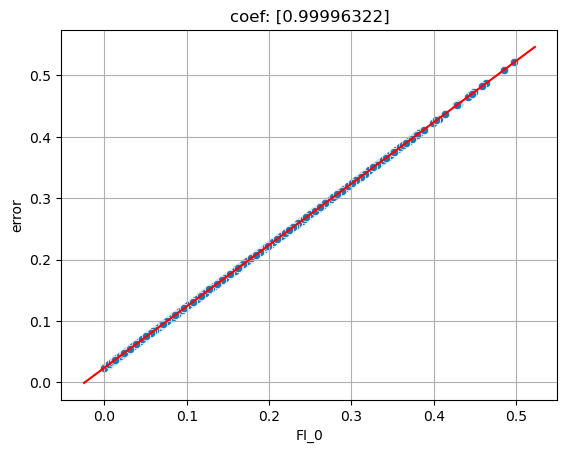

In [79]:
plot_on_endpoints(biomarkers,"nn_cmb_met_ajive_frailty", frailty_set2, frailty_set2, show_figure = True)

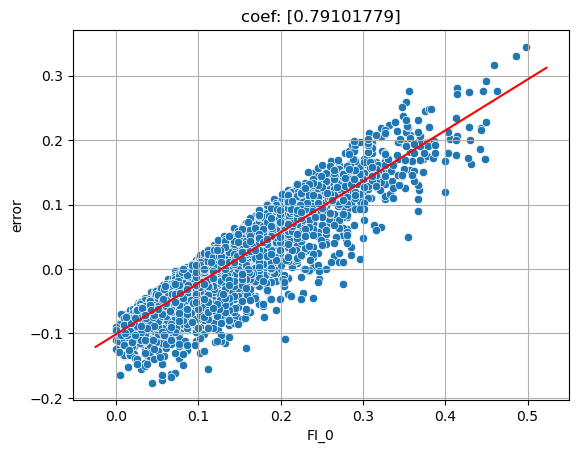

In [56]:
plot_on_endpoints(biomarkers, "nn_cmb_ffs_frailty", frailty_set2, frailty_set2)

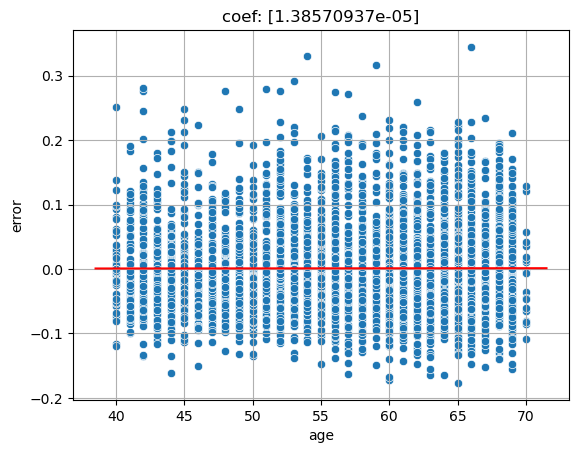

In [89]:
_, err_age = plot_on_endpoints(biomarkers, "nn_cmb_ffs_frailty", frailty_set2, age)

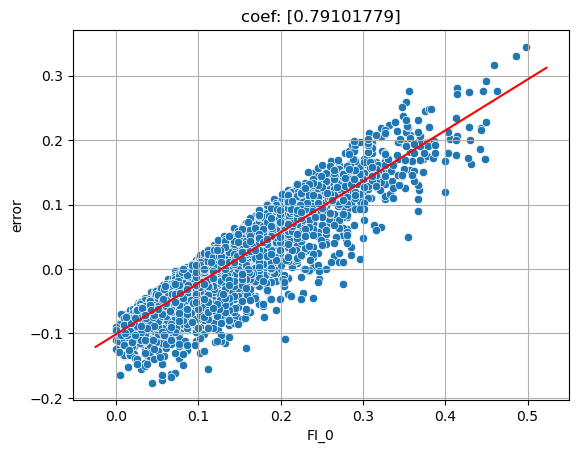

In [91]:
_, err_ft = plot_on_endpoints(biomarkers, "nn_cmb_ffs_frailty", frailty_set2, frailty_set2)

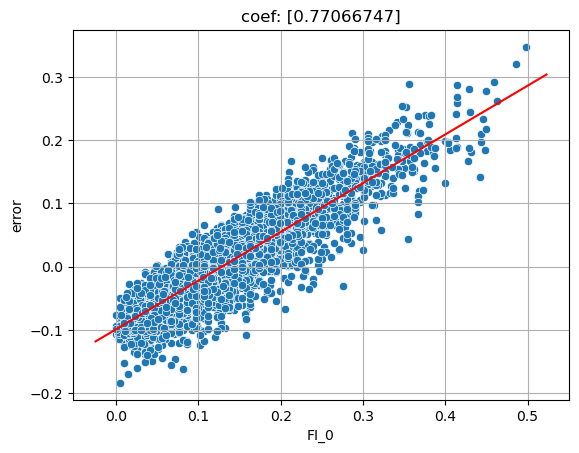

In [57]:
plot_on_endpoints(biomarkers, "en_frailty_cmb", frailty_set2, frailty_set2)

In [27]:
frailty_set2.head()

FI_0
eid              
4516850  0.222449
4517099  0.010204
4517165  0.173469
4517441  0.306122
4517585  0.134694

In [26]:
biomarkers.head()

en_mort_cmb  en_mort_cmb_sub  en_mort_cmb_met  en_mort_cmb_met_pca  \
4523051.0    -1.454485        -1.473683        -1.411170            -0.077860   
4533555.0     0.277077         0.493338         0.316635             0.101200   
4536185.0     0.103772         0.071769         0.145304            -0.529814   
4545374.0    -1.282478        -1.324727        -1.202487            -0.568815   
4545590.0     0.188728         0.116117         0.164645            -0.099236   

           en_mort_cmb_met_pca20  en_mort_cmb_met_ajive10  en_boot_mort  \
4523051.0              -0.654124                -0.142327     -0.571664   
4533555.0               0.373463                -0.094387      0.519160   
4536185.0               0.125342                -0.843444     -0.307028   
4545374.0              -0.561922                 0.024393     -0.696838   
4545590.0               0.220547                -0.087829      0.253661   

           en_mort_cmb_met_ffs  en_mort_cmb_mh  en_GDF15_MH_mort  ...  \
4523051.0            -0.354538       -1.470235          0.214653  ...   
4533555.0             0.060651        0.491672          0.019788  ...   
4536185.0            -0.798555        0.069549         -0.555388  ...   
4545374.0            -0.174831       -1.323461         -0.120692  ...   
4545590.0             0.209113        0.117813          0.535913  ...   

           nn_cmb_clust_mort  nn_cmb_met_frailty  nn_cmb_mh_frailty  \
4523051.0          -0.127189            0.112018           0.101423   
4533555.0          -0.130695            0.143990           0.148601   
4536185.0          -0.138721            0.102692           0.089161   
4545374.0          -0.153869            0.111743           0.105132   
4545590.0          -0.103325            0.132927           0.148808   

           nn_cmb_met_pca20_frailty  nn_cmb_met_ajive_frailty  \
4523051.0                  0.173319                 -0.023713   
4533555.0                  0.173394                 -0.023713   
4536185.0                  0.172326                 -0.023763   
4545374.0                  0.172877                 -0.023713   
4545590.0                  0.173394                 -0.023713   

           nn_cmb_met_pca_frailty  nn_cmb_clust_frailty  nn_cmb_ffs_frailty  \
4523051.0               -0.105398              0.101038            0.104811   
4533555.0               -0.105396              0.154417            0.172222   
4536185.0               -0.105458              0.065705            0.096125   
4545374.0               -0.105432              0.109102            0.104575   
4545590.0               -0.105396              0.167603            0.148644   

           nn_cmb_met_ffs_frailty  nn_allprot_ffs_frailty  
4523051.0                0.092542                0.108205  
4533555.0                0.151174                0.142409  
4536185.0                0.082967                0.088240  
4545374.0                0.104979                0.100272  
4545590.0                0.135092                0.127536  

[5 rows x 42 columns]

In [45]:
nn_combined_data.head

<bound method NDFrame.head of Empty DataFrame
Columns: [nn_allprot_mort, nn_cmb_mort, nn_cmb_sub_mort, nn_cmb_met_mort, nn_cmb_met_pca_mort, nn_cmb_mh_mort, nn_cmb_met_pca20_mort, nn_cmb_met_ajive_mort, nn_cmb_4050_mort, nn_cmb_5060_mort, nn_cmb_6070_mort, nn_cmb_clust_mort, nn_cmb_met_frailty_x, nn_cmb_mh_frailty_x, nn_cmb_met_pca20_frailty_x, nn_cmb_met_ajive_frailty_x, nn_cmb_met_pca_frailty_x, nn_cmb_4050_frailty_x, nn_cmb_5060_frailty_x, nn_cmb_6070_frailty_x, nn_cmb_clust_frailty_x, nn_cmb_ffs_frailty_x, nn_cmb_met_ffs_frailty_x, nn_allprot_ffs_frailty_x, nn_cmb_met_frailty_y, nn_cmb_mh_frailty_y, nn_cmb_met_pca20_frailty_y, nn_cmb_met_ajive_frailty_y, nn_cmb_met_pca_frailty_y, nn_cmb_4050_frailty_y, nn_cmb_5060_frailty_y, nn_cmb_6070_frailty_y, nn_cmb_clust_frailty_y, nn_cmb_ffs_frailty_y, nn_cmb_met_ffs_frailty_y, nn_allprot_ffs_frailty_y]
Index: []>

In [20]:
#MetaboHealth
metabohealth = pd.read_csv('./Data/Round0_MiMIR_MetaboHealth.csv', index_col = 'eid')
metabohealth.dropna(how='any', inplace=True)

#Lifestyle factors
lifestyle = pd.read_csv('./Data/UKB_Lifestyle.csv', index_col = 'eid')
lifestyle.drop('sex', axis=1, inplace=True)

# Create a list of DataFrames to merge to compare with other biomarkers
dfs_to_merge = [biomarkers, metabohealth, set2_proteins['GDF15'], set2_mort, age, lifestyle]
compare_df = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True), dfs_to_merge)
compare_df.head()

en_mort_cmb  en_mort_cmb_sub  en_mort_cmb_met  en_mort_cmb_met_pca  \
4523051.0    -1.454485        -1.473683        -1.411170            -0.077860   
4533555.0     0.277077         0.493338         0.316635             0.101200   
4536185.0     0.103772         0.071769         0.145304            -0.529814   
4545374.0    -1.282478        -1.324727        -1.202487            -0.568815   
4545590.0     0.188728         0.116117         0.164645            -0.099236   

           en_mort_cmb_met_pca20  en_mort_cmb_met_ajive10  en_boot_mort  \
4523051.0              -0.654124                -0.142327     -0.571664   
4533555.0               0.373463                -0.094387      0.519160   
4536185.0               0.125342                -0.843444     -0.307028   
4545374.0              -0.561922                 0.024393     -0.696838   
4545590.0               0.220547                -0.087829      0.253661   

           en_mort_allprot_ffs  en_mort_cmb_ffs  en_mort_cmb_met_ffs  ...  \
4523051.0            -0.408508        -0.235590            -0.354538  ...   
4533555.0            -0.041965        -0.022389             0.060651  ...   
4536185.0            -0.575933        -0.859223            -0.798555  ...   
4545374.0            -0.477448        -0.295342            -0.174831  ...   
4545590.0             0.257272         0.342205             0.209113  ...   

           dietscore.3.0  season.3.0  age.3.0  smokingfrq.3.0  smokingyn.3.0  \
4523051.0            NaN         NaN      NaN             NaN            NaN   
4533555.0            NaN         NaN      NaN             NaN            NaN   
4536185.0            NaN         NaN      NaN             NaN            NaN   
4545374.0            NaN         NaN      NaN             NaN            NaN   
4545590.0            NaN         NaN      NaN             NaN            NaN   

           sleepH.3.0  sleepS.3.0  sleep.3.0  ses.0.0  ses.1.0  
4523051.0         NaN         NaN        NaN      3.0      NaN  
4533555.0         NaN         NaN        NaN      3.0      NaN  
4536185.0         NaN         NaN        NaN      1.0      NaN  
4545374.0         NaN         NaN        NaN      2.0      3.0  
4545590.0         NaN         NaN        NaN      1.0      NaN  

[5 rows x 282 columns]

In [21]:
lifestyle.columns

Index(['waist.0.0', 'waist.1.0', 'waist.2.0', 'waist.3.0', 'bmi.0.0',
       'bmi.1.0', 'bmi.2.0', 'bmi.3.0', 'metmod.0.0', 'metvig.0.0',
       ...
       'dietscore.3.0', 'season.3.0', 'age.3.0', 'smokingfrq.3.0',
       'smokingyn.3.0', 'sleepH.3.0', 'sleepS.3.0', 'sleep.3.0', 'ses.0.0',
       'ses.1.0'],
      dtype='object', length=247)

## Correleren

In [47]:
dfs_to_cor = [biomarkers, metabohealth, set2_proteins['GDF15'], age]
cor_df = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True), dfs_to_cor)

# Save columns with biomarkers
protein_columns = [col for col in cor_df.columns if col.startswith('en_') or col.startswith('nn_') or col == 'GDF15' or col == 'mortScore']

# Linear regression for each column
for col in protein_columns:
    # Extracting X (age) and y (the column to regress on)     
    X = cor_df['age'].values.reshape(-1, 1)     
    y = cor_df[col].values.reshape(-1, 1)
    
    # Fitting linear regression model to determine Age Acceleration
    aa_model = LinearRegression()
    aa_model.fit(X, y)
    
    # Calculating residuals
    residuals = y - aa_model.predict(X)
    
    # Creating new column for residuals
    new_col_name = 'aa_' + col
    cor_df[new_col_name] = residuals



In [48]:
protein_columns

['en_mort_cmb',
 'en_mort_cmb_sub',
 'en_mort_cmb_met',
 'en_mort_cmb_met_pca',
 'en_mort_cmb_met_pca20',
 'en_mort_cmb_met_ajive10',
 'en_boot_mort',
 'en_mort_cmb_met_ffs',
 'en_mort_cmb_mh',
 'en_GDF15_MH_mort',
 'en_frailty_allprot',
 'en_frailty_cmb',
 'en_frailty_cmb_sub',
 'en_frailty_cmb_met',
 'en_frailty_cmb_met_pca',
 'en_frailty_cmb_met_pca20',
 'en_frailty_cmb_met_ajive10',
 'en_cluster_200_frailty_cmb_met',
 'en_bootcols',
 'en_frailty_allprot_ffs',
 'en_frailty_cmb_ffs',
 'en_frailty_cmb_met_ffs',
 'en_frailty_cmb_mh',
 'en_GDF15_MH_frail',
 'nn_allprot_mort',
 'nn_cmb_mort',
 'nn_cmb_sub_mort',
 'nn_cmb_met_mort',
 'nn_cmb_met_pca_mort',
 'nn_cmb_mh_mort',
 'nn_cmb_met_pca20_mort',
 'nn_cmb_met_ajive_mort',
 'nn_cmb_clust_mort',
 'nn_cmb_met_frailty',
 'nn_cmb_mh_frailty',
 'nn_cmb_met_pca20_frailty',
 'nn_cmb_met_ajive_frailty',
 'nn_cmb_met_pca_frailty',
 'nn_cmb_clust_frailty',
 'nn_cmb_ffs_frailty',
 'nn_cmb_met_ffs_frailty',
 'nn_allprot_ffs_frailty',
 'mortScore',

In [49]:
list(cor_df)

['en_mort_cmb',
 'en_mort_cmb_sub',
 'en_mort_cmb_met',
 'en_mort_cmb_met_pca',
 'en_mort_cmb_met_pca20',
 'en_mort_cmb_met_ajive10',
 'en_boot_mort',
 'en_mort_cmb_met_ffs',
 'en_mort_cmb_mh',
 'en_GDF15_MH_mort',
 'en_frailty_allprot',
 'en_frailty_cmb',
 'en_frailty_cmb_sub',
 'en_frailty_cmb_met',
 'en_frailty_cmb_met_pca',
 'en_frailty_cmb_met_pca20',
 'en_frailty_cmb_met_ajive10',
 'en_cluster_200_frailty_cmb_met',
 'en_bootcols',
 'en_frailty_allprot_ffs',
 'en_frailty_cmb_ffs',
 'en_frailty_cmb_met_ffs',
 'en_frailty_cmb_mh',
 'en_GDF15_MH_frail',
 'nn_allprot_mort',
 'nn_cmb_mort',
 'nn_cmb_sub_mort',
 'nn_cmb_met_mort',
 'nn_cmb_met_pca_mort',
 'nn_cmb_mh_mort',
 'nn_cmb_met_pca20_mort',
 'nn_cmb_met_ajive_mort',
 'nn_cmb_clust_mort',
 'nn_cmb_met_frailty',
 'nn_cmb_mh_frailty',
 'nn_cmb_met_pca20_frailty',
 'nn_cmb_met_ajive_frailty',
 'nn_cmb_met_pca_frailty',
 'nn_cmb_clust_frailty',
 'nn_cmb_ffs_frailty',
 'nn_cmb_met_ffs_frailty',
 'nn_allprot_ffs_frailty',
 'mortScore',

Index(['aa_en_mort_cmb', 'aa_en_mort_cmb_sub', 'aa_en_mort_cmb_met',
       'aa_en_mort_cmb_met_pca', 'aa_en_mort_cmb_met_pca20',
       'aa_en_mort_cmb_met_ajive10', 'aa_en_boot_mort',
       'aa_en_mort_cmb_met_ffs', 'aa_en_mort_cmb_mh', 'aa_en_GDF15_MH_mort',
       'aa_en_frailty_allprot', 'aa_en_frailty_cmb', 'aa_en_frailty_cmb_sub',
       'aa_en_frailty_cmb_met', 'aa_en_frailty_cmb_met_pca',
       'aa_en_frailty_cmb_met_pca20', 'aa_en_frailty_cmb_met_ajive10',
       'aa_en_cluster_200_frailty_cmb_met', 'aa_en_bootcols',
       'aa_en_frailty_allprot_ffs', 'aa_en_frailty_cmb_ffs',
       'aa_en_frailty_cmb_met_ffs', 'aa_en_frailty_cmb_mh',
       'aa_en_GDF15_MH_frail', 'aa_nn_allprot_mort', 'aa_nn_cmb_mort',
       'aa_nn_cmb_sub_mort', 'aa_nn_cmb_met_mort', 'aa_nn_cmb_met_pca_mort',
       'aa_nn_cmb_mh_mort', 'aa_nn_cmb_met_pca20_mort',
       'aa_nn_cmb_met_ajive_mort', 'aa_nn_cmb_clust_mort',
       'aa_nn_cmb_met_frailty', 'aa_nn_cmb_mh_frailty',
       'aa_nn_cmb_met_pca

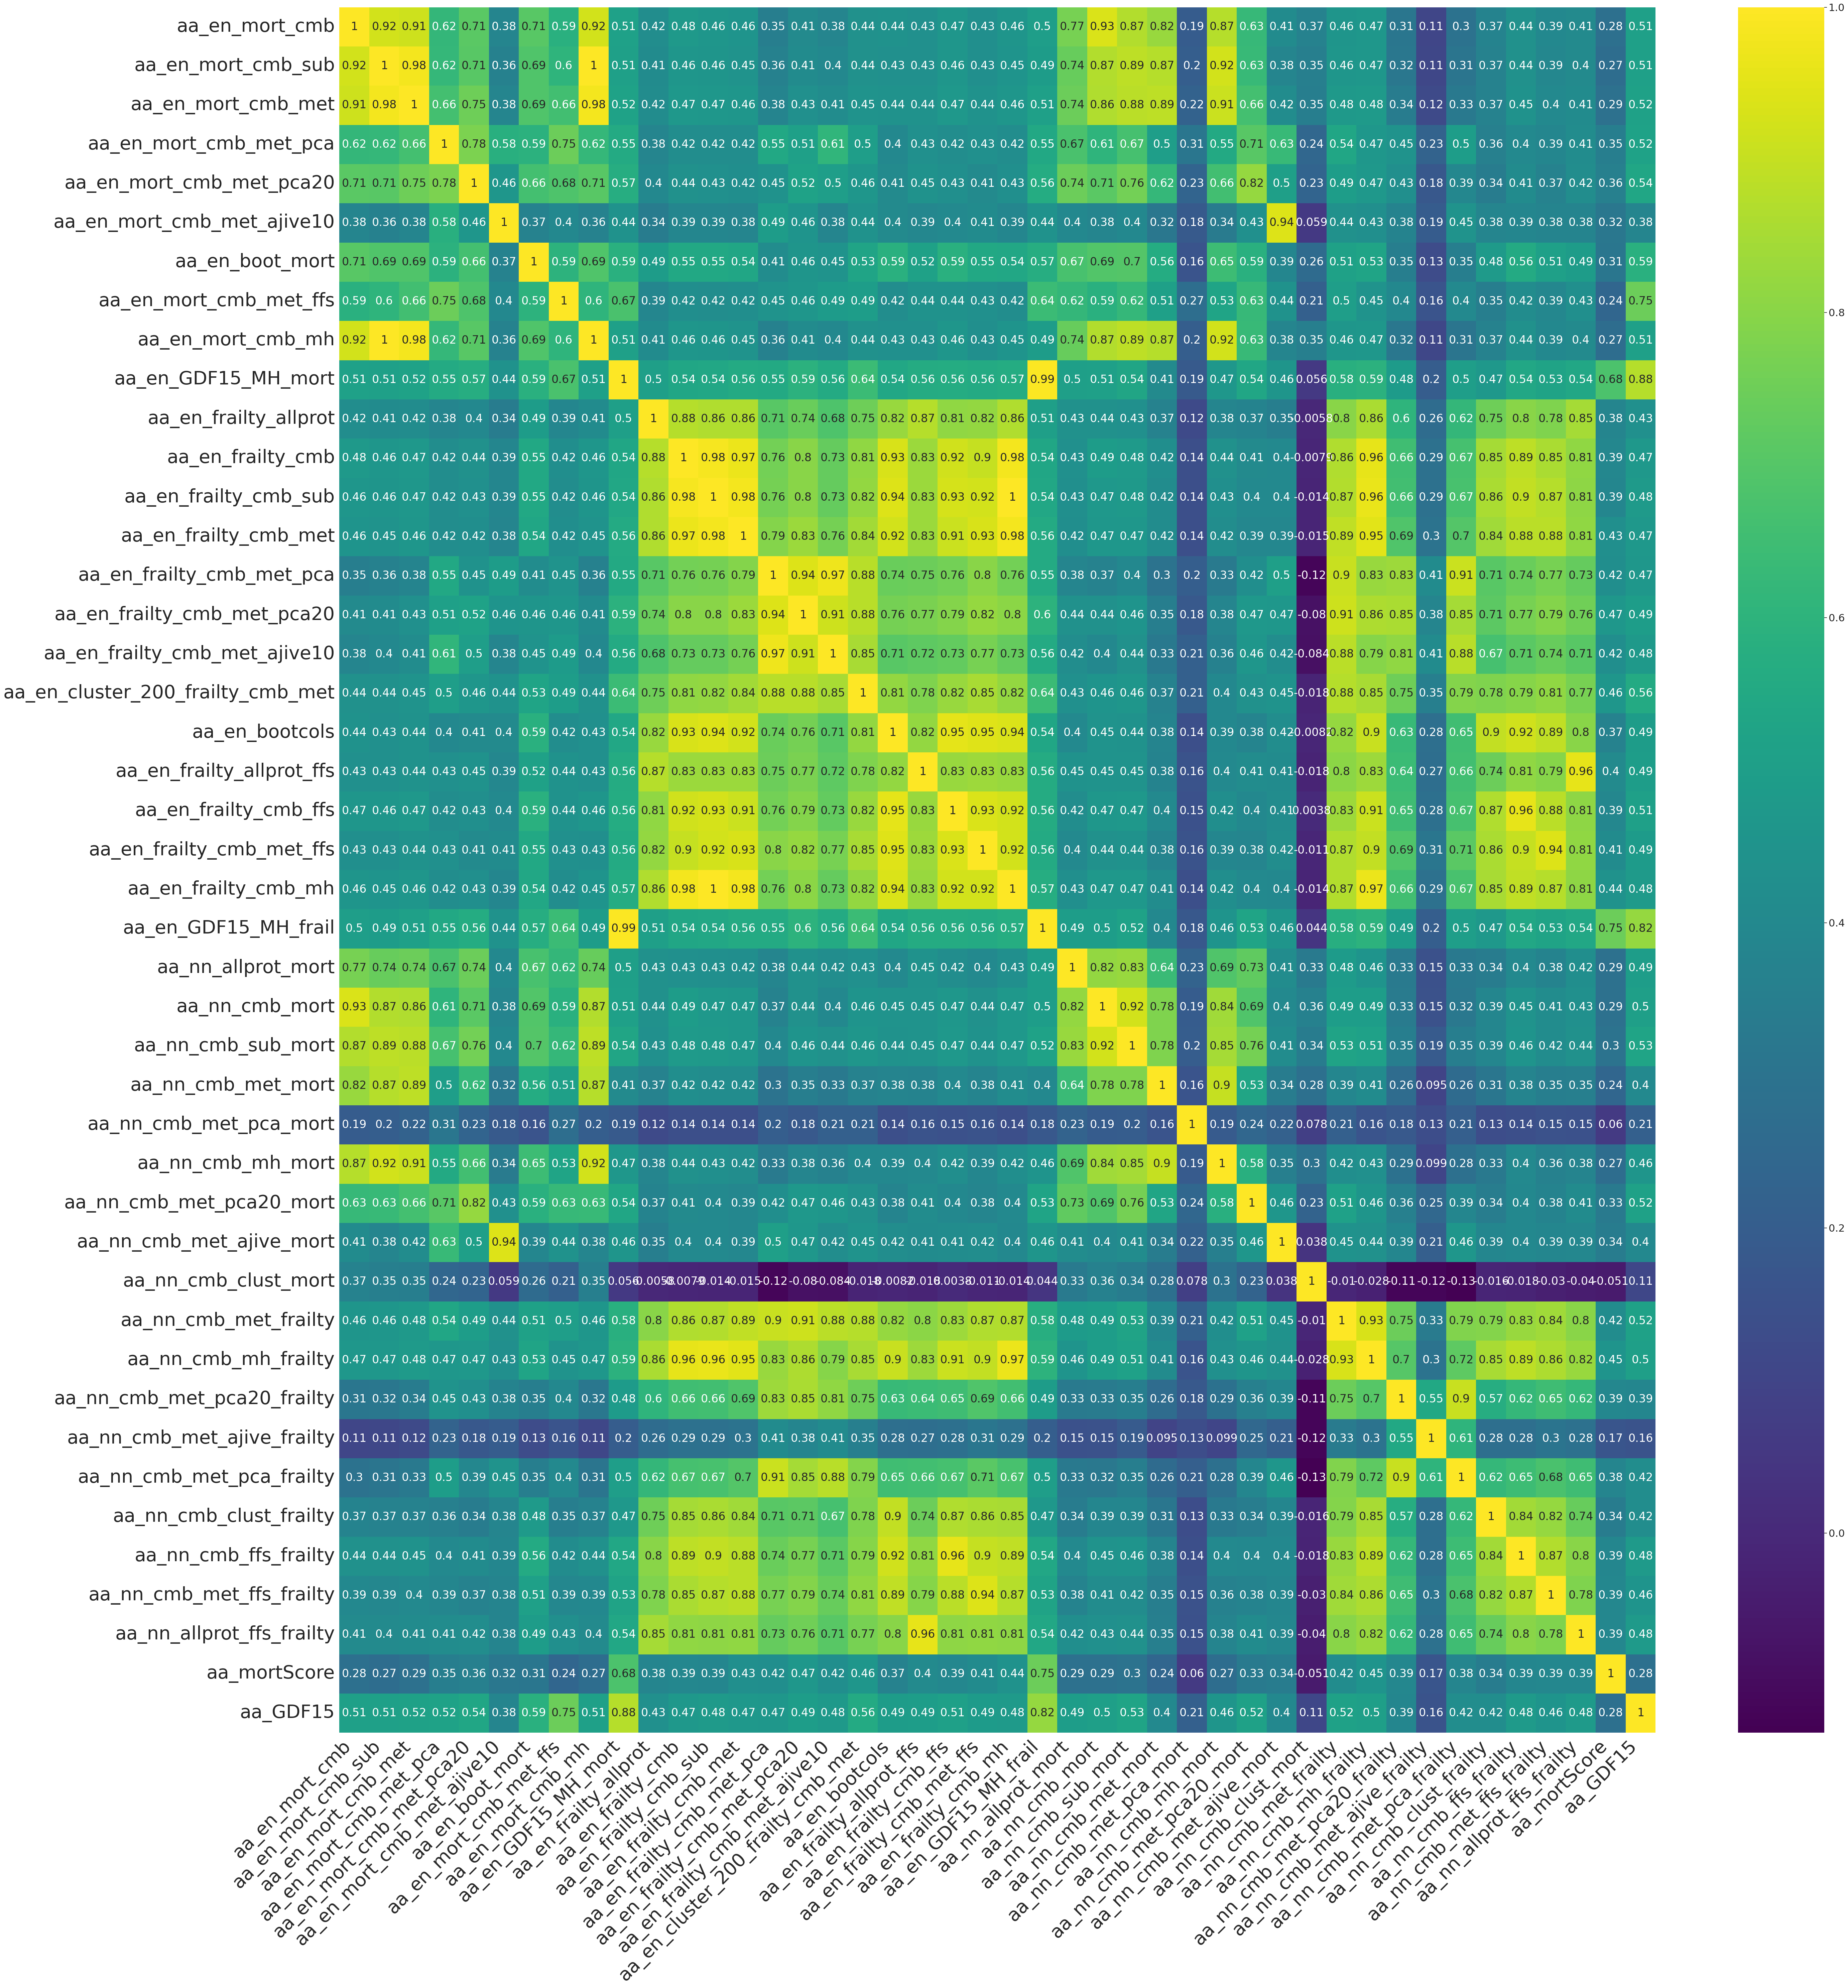

In [50]:
corraabiomarkers = cor_df.drop(columns=[col for col in cor_df.columns if not col.startswith('aa_')])
corraabiomarkers.columns = map(lambda x: x.replace('_proteins', ''), corraabiomarkers.columns)
print(corraabiomarkers.columns)

#corraabiomarkers_new = corraabiomarkers.reindex(columns = ['age', 'en_mort_all', 'en_mort_cmb', 'nnet_cmb', 'en_fi_all', 'en_fi_cmb','aa_en_mort_all', 'aa_en_mort_cmb', 'aa_nnet_cmb', 'aa_en_fi_all', 'aa_en_fi_cmb']).corr(method='spearman')
corraabiomarkers_cor = corraabiomarkers.corr(method='spearman')

# Create heatmap
# Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(corraabiomarkers_new, dtype=bool))
fig, ax = plt.subplots(figsize=(60, 60))  # Adjust the size as per your preference
sns.set(font_scale=2)
corraabiomarkers_plot = sns.heatmap(corraabiomarkers_cor, cmap="viridis", annot=True, ax=ax)
plt.yticks(fontsize=40) 
plt.xticks(fontsize=40,rotation=45, ha='right') 
plt.tight_layout()

# Display the plot
#plt.show()
plt.savefig("correlations.svg", backend='svg', transparent=True)

In [36]:
corraabiomarkers_plot

<Axes: >

In [51]:
#Cox Model
cph_lifelines = CoxPHFitter()
scaler = StandardScaler()
model1 = compare_df[['en_mort_cmb','sex','censorage', 'died']]
model1[['en_mort_cmb']] = scaler.fit_transform(model1[['en_mort_cmb']])
cph_lifelines.fit(model1, "censorage", "died")
cph_lifelines.print_summary()


/tmp/ipykernel_911350/2925034459.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model1[['en_mort_cmb']] = scaler.fit_transform(model1[['en_mort_cmb']])


<lifelines.CoxPHFitter: fitted with 4320 total observations, 3856 right-censored observations>
             duration col = 'censorage'
                event col = 'died'
      baseline estimation = breslow
   number of observations = 4320
number of events observed = 464
   partial log-likelihood = -3324.07
         time fit was run = 2024-10-30 11:10:24 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
en_mort_cmb  0.60      1.81      0.03            0.53            0.66                1.70                1.94
sex         -0.08      0.93      0.10           -0.27            0.11                0.77                1.12

             cmp to     z      p  -log2(p)
covariate                                 
en_mort_cmb    0.00 17.33 <0.005    221.06
sex            0.00 -0.80   0.42      1.25
---
Concordance = 0.70
Partial AIC = 6652.15
log-likelihood ratio test = 245.64 on 2 df
-log2(p) of ll-ratio test = 177.20

In [37]:
biomarkers.columns

Index(['en_mort_cmb', 'en_mort_cmb_sub', 'en_mort_cmb_met',
       'en_mort_cmb_met_pca', 'en_mort_cmb_met_pca20',
       'en_mort_cmb_met_ajive10', 'en_boot_mort', 'en_mort_allprot_ffs',
       'en_mort_cmb_ffs', 'en_mort_cmb_met_ffs', 'en_mort_cmb_mh',
       'en_GDF15_MH_mort', 'en_frailty_allprot', 'en_frailty_cmb',
       'en_frailty_cmb_sub', 'en_frailty_cmb_met', 'en_frailty_cmb_met_pca',
       'en_frailty_cmb_met_pca20', 'en_frailty_cmb_met_ajive10',
       'en_cluster_200_frailty_cmb_met', 'en_bootcols',
       'en_frailty_allprot_ffs', 'en_frailty_cmb_ffs',
       'en_frailty_cmb_met_ffs', 'en_frailty_cmb_mh', 'en_GDF15_MH_frail',
       'nn_allprot_mort', 'nn_cmb_mort'],
      dtype='object')

In [31]:
compare_df.columns

Index(['en_mort_cmb', 'en_mort_cmb_sub', 'en_mort_cmb_met',
       'en_mort_cmb_met_pca', 'en_mort_cmb_met_pca20',
       'en_mort_cmb_met_ajive10', 'en_boot_mort', 'en_mort_allprot_ffs',
       'en_mort_cmb_ffs', 'en_mort_cmb_met_ffs',
       ...
       'dietscore.3.0', 'season.3.0', 'age.3.0', 'smokingfrq.3.0',
       'smokingyn.3.0', 'sleepH.3.0', 'sleepS.3.0', 'sleep.3.0', 'ses.0.0',
       'ses.1.0'],
      dtype='object', length=282)

In [39]:
column = 'nn_cmb_mort'
model_data = compare_df[[column] + ['smokingyn.0.0']].copy()
model_data.dropna(how='any', inplace=True)
y = model_data[column]
X = model_data['smokingyn.0.0']
OLS(y, add_constant(X, prepend = False)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            nn_cmb_mort   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     594.9
Date:                Fri, 08 Nov 2024   Prob (F-statistic):          3.33e-123
Time:                        15:58:31   Log-Likelihood:                -3289.3
No. Observations:                4313   AIC:                             6583.
Df Residuals:                    4311   BIC:                             6595.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
smokingyn.0.0     0.6380      0.026     24.391      0.000       0.587       0.689
const             0.3539      0.008     42.460      0.000       0.338       0.370
==============================================================================
Omnibus:                     2336.072   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24715.995
Skew:                           2.378   Prob(JB):                         0.00
Kurtosis:                      13.720   Cond. No.                         3.35
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#Mortality analyses
# Initialize CoxPHFitter
cph_lifelines = CoxPHFitter()

# Prepare dataframe for coefficients
coefs = pd.DataFrame(columns=['variable', 'model','N', 'N_event', 'coef', 'se(coef)', 'exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%', 'p', 'C'])

# Additional columns to consider
additional_columns = [['sex'], ['sex', 'ses.0.0'], ['sex', 'ses.0.0','smokingyn.0.0', 'bmi.0.0'], ['sex', 'ses.0.0','smokingyn.0.0', 'bmi.0.0', 'lymf.0.0', 'mono.0.0']]

# Initialize scaler
scaler = StandardScaler()

# Iterate through columns in compare_df
for ageaccel in [True, False]:
    for column in compare_df.columns:
        if column.startswith('en_') or column.startswith('nn_') or column == 'GDF15' or column == 'mortScore':
            for i in range(len(additional_columns)): 
                model_data = compare_df[[column] + additional_columns[i] + ['age','censorage', 'died']].copy()
                # Drop rows with NaN values
                model_data.dropna(how='any', inplace=True)
                
                if ageaccel:
                     # Extracting X (age) and y (the column to regress on)     
                    X = model_data['age'].values.reshape(-1, 1)     
                    y = model_data[column].values.reshape(-1, 1)
                    # Fitting linear regression model to determine Age Acceleration
                    aa_model = LinearRegression()
                    aa_model.fit(X, y)
        
                    # Calculating residuals
                    residuals = y - aa_model.predict(X)
            
                    # Creating new column for residuals
                    model_data[[column]] = residuals
    
                # Scale the column of interest
                model_data[[column]] = scaler.fit_transform(model_data[[column]])
                model_data.drop('age', axis =1, inplace=True)
    
                
                try:
                    # Fit the Cox model
                    cph_lifelines.fit(model_data, "censorage", "died")
                    
                    # Get summary data
                    summary = cph_lifelines.summary
                    
                    # Extract coefficients for the column of interest
                    coef_values = summary.loc[[column], ['coef', 'se(coef)', 'exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%', 'p']].copy()
                    
                    # Add additional information
                    coef_values['variable'] = f'aa_{column}' if ageaccel else column
                    coef_values['model'] = i
                    coef_values['N'] = len(cph_lifelines.durations)
                    coef_values['N_event'] = cph_lifelines.event_observed.sum()
                    coef_values['C'] = cph_lifelines.concordance_index_
                    
                    # Reorder columns
                    coef_values = coef_values[['variable', 'model','N', 'N_event', 'coef', 'se(coef)', 'exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%', 'p', 'C']]
                    
                    # Append to coefs dataframe
                    coefs = pd.concat([coefs, coef_values], ignore_index=True)
                    
                except Exception as e:
                    print(f"Error fitting Cox model for {column}: {e}")

# Display or return the coefficients dataframe
coefs['HR_CI'] = coefs.apply(lambda row: f"{round(row['exp(coef)'],2)} ({round(row['exp(coef) lower 95%'],2)}; {round(row['exp(coef) upper 95%'],2)})", axis=1)
coefs['Concordance'] = round(coefs['C'],2)

print("Final Coefficients DataFrame:")
print(coefs)

coefs.to_csv('intermediate_results/olink_scaled_biomarkers_mortality.csv', index = False)

/tmp/ipykernel_911350/3559955754.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  coefs = pd.concat([coefs, coef_values], ignore_index=True)


In [ ]:
model1 = coefs.loc[coefs['model']==1]
# Create HR_CI
model1['HR_CI'] = model1.apply(lambda row: f"{round(row['exp(coef)'],2)} ({round(row['exp(coef) lower 95%'],2)}; {round(row['exp(coef) upper 95%'],2)})", axis=1)
model1['Concordance'] = round(model1['C'],2)
model1['HR_CI'].head()
model1[['variable','HR_CI','Concordance']]

In [ ]:
model0 = coefs.loc[coefs['model']==0]
# Create HR_CI
model0['HR_CI'] = model0.apply(lambda row: f"{round(row['exp(coef)'],2)} ({round(row['exp(coef) lower 95%'],2)}; {round(row['exp(coef) upper 95%'],2)})", axis=1)
model0['Concordance'] = round(model0['C'],2)
model0['HR_CI'].head()
model0[['variable','HR_CI','Concordance']]

In [ ]:
model0_allprotnn = coefs[coefs['variable'] == 'aa_nn_allprot_mort']
model0_allprotnn

In [ ]:
# Set pandas display options for your full table
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Generate your table data
table_data = model0[['variable', 'HR_CI', 'Concordance']]

# Create a matplotlib figure
fig, ax = plt.subplots(figsize=(10, len(table_data) * 0.5))  # Adjust height dynamically based on rows

# Hide the axes
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False)
ax.set_frame_on(False) 

# Create a table on the plot
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, cellLoc='center', loc='center')

# Adjust table settings
table.scale(1, 1.5)  # Scale table to fit content
table.auto_set_font_size(False)
table.set_fontsize(10)

# Save the plot as an image file
plt.savefig("dataframe_image.png", bbox_inches='tight', dpi=300)

plt.show()  # If you want to display the image as well


In [26]:
# Frailty
# Add frailty to compare_df and create compare_frailty
compare_frailty = compare_df.merge(frailty_set2, left_index=True, right_index=True)

# Additional columns to consider
frailty_additional_columns = [['FI_0', 'age'],
                              ['FI_0','age'], 
                              ['FI_0','age', 'sex'], 
                              ['FI_0','age', 'sex', 'ses.0.0'], 
                              ['FI_0','age', 'sex', 'ses.0.0', 'smokingyn.0.0', 'bmi.0.0'], 
                              ['FI_0','age', 'sex', 'ses.0.0', 'smokingyn.0.0', 'bmi.0.0', 'lymf.0.0', 'mono.0.0']]

# Initialize scaler
scaler = StandardScaler()
results = []

# Iterate through columns in compare_frailty
for ageaccel in [True, False]:
    for column in compare_frailty.columns:
        if column.startswith('en_') or column.startswith('nn_') or column == 'GDF15' or column == 'mortScore':
            for i in range(len(frailty_additional_columns)): 
            #for i in range(1): 
                model_data = compare_frailty[[column] + frailty_additional_columns[i]].copy()
                # Drop rows with NaN values
                model_data.dropna(how='any', inplace=True)
                if ageaccel:
                    # Extracting X (age) and y (the column to regress on)     
                    Xres = model_data['age'].values.reshape(-1, 1)     
                    yres = model_data[column].values.reshape(-1, 1)
                    # Fitting linear regression model to determine Age Acceleration
                    aa_model = LinearRegression()
                    aa_model.fit(Xres, yres)
        
                    # Calculating residuals
                    residuals = yres - aa_model.predict(Xres)
            
                    # Creating new column for residuals
                    model_data[[column]] = residuals
                # Scale the column of interest
                model_data[[column]] = scaler.fit_transform(model_data[[column]])

                if i == 0: #we want to make an analysis without age adjustment so also no age coef
                    model_data.drop(columns=['age'], inplace=True)

                # Make frailty outcome
                X = model_data.drop(columns=['FI_0'])
                y = model_data['FI_0']
    
                # Fit the model
                reg = OLS(y, add_constant(X, prepend = False)).fit()
                summary = reg.summary()
                #print(summary)
                # Extract coefficients and stats for biomarkers
                col_index = 1  # Is the first column after the header as selected in model_data as first
                coef = summary.tables[1].data[col_index][1]
                std_err = summary.tables[1].data[col_index][2]
                t_value = summary.tables[1].data[col_index][3]
                p_value = summary.tables[1].data[col_index][4]
                conf_int_025 = summary.tables[1].data[col_index][5]
                conf_int_975 = summary.tables[1].data[col_index][6]
                if i != 0:
                    age_coef = summary.tables[1].data[2][1]
                    age_ll = summary.tables[1].data[2][5]
                    age_ul = summary.tables[1].data[2][6]
                else: #we want to make an analysis without age adjustment so also no age coef
                    age_coef = np.NaN
                    age_ll = np.NaN
                    age_ul = np.NaN
                    
                # R-squared
                r_squared = reg.rsquared
                
                # Store results for this iteration
                results.append({
                    'variable': f'aa_{column}' if ageaccel else column,
                    'model': i,
                    'N': len(y),
                    'Coef': coef,
                    'Std Err': std_err,
                    't-value': t_value,
                    'P': p_value,
                    'LL': conf_int_025,
                    'UL': conf_int_975,
                    'R-squared': r_squared,
                    'Age_coef': age_coef,
                    'Age_LL': age_ll,
                    'Age_UL': age_ul
            })

# Convert results list to pandas DataFrame
results_df = pd.DataFrame(results)
results_df['Beta_CI'] = results_df.apply(lambda row: f"{row['Coef']} ({row['LL']}; {row['UL']})", axis=1)
results_df['R2'] = round(results_df['R-squared'],2)
print(results_df)
results_df.to_csv('intermediate_results/olink_scaled_biomarkers_frailty.csv', index = False)

                              variable  model     N        Coef    Std Err  \
0                       aa_en_mort_cmb      0  4320      0.0218      0.001   
1                       aa_en_mort_cmb      1  4320      0.0218      0.001   
2                       aa_en_mort_cmb      2  4320      0.0246      0.001   
3                       aa_en_mort_cmb      3  4264      0.0223      0.001   
4                       aa_en_mort_cmb      4  4243      0.0203      0.001   
5                       aa_en_mort_cmb      5  4122      0.0197      0.001   
6                   aa_en_mort_cmb_sub      0  4320      0.0207      0.001   
7                   aa_en_mort_cmb_sub      1  4320      0.0207      0.001   
8                   aa_en_mort_cmb_sub      2  4320      0.0237      0.001   
9                   aa_en_mort_cmb_sub      3  4264      0.0213      0.001   
10                  aa_en_mort_cmb_sub      4  4243      0.0190      0.001   
11                  aa_en_mort_cmb_sub      5  4122      0.0182 

In [27]:
compare_frailty['FI_0'].describe()

count    4320.000000
mean        0.129323
std         0.077823
min         0.000000
25%         0.075510
50%         0.112245
75%         0.168367
max         0.497959
Name: FI_0, dtype: float64

In [28]:
model0 = results_df.loc[results_df['model']==0]
# Create Beta_CI
model0['Beta_CI'] = model0.apply(lambda row: f"{row['Coef']} ({row['LL']}; {row['UL']})", axis=1)
model0['R2'] = round(model0['R-squared'],2)

model0[['variable','Beta_CI','R2']]

/tmp/ipykernel_911350/3133033212.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model0['Beta_CI'] = model0.apply(lambda row: f"{row['Coef']} ({row['LL']}; {row['UL']})", axis=1)
/tmp/ipykernel_911350/3133033212.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model0['R2'] = round(model0['R-squared'],2)


variable                            Beta_CI  \
0                       aa_en_mort_cmb      0.0218 (    0.020;     0.024)   
6                   aa_en_mort_cmb_sub      0.0207 (    0.018;     0.023)   
12                  aa_en_mort_cmb_met      0.0215 (    0.019;     0.024)   
18              aa_en_mort_cmb_met_pca      0.0208 (    0.019;     0.023)   
24            aa_en_mort_cmb_met_pca20      0.0220 (    0.020;     0.024)   
30          aa_en_mort_cmb_met_ajive10      0.0184 (    0.016;     0.021)   
36                     aa_en_boot_mort      0.0233 (    0.021;     0.025)   
42              aa_en_mort_cmb_met_ffs      0.0213 (    0.019;     0.024)   
48                   aa_en_mort_cmb_mh      0.0207 (    0.018;     0.023)   
54                 aa_en_GDF15_MH_mort      0.0245 (    0.022;     0.027)   
60               aa_en_frailty_allprot      0.0400 (    0.038;     0.042)   
66                   aa_en_frailty_cmb      0.0372 (    0.035;     0.039)   
72               aa_en_frailty_cmb_sub      0.0365 (    0.034;     0.039)   
78               aa_en_frailty_cmb_met      0.0371 (    0.035;     0.039)   
84           aa_en_frailty_cmb_met_pca      0.0310 (    0.029;     0.033)   
90         aa_en_frailty_cmb_met_pca20      0.0325 (    0.030;     0.035)   
96       aa_en_frailty_cmb_met_ajive10      0.0303 (    0.028;     0.032)   
102  aa_en_cluster_200_frailty_cmb_met      0.0326 (    0.031;     0.035)   
108                     aa_en_bootcols      0.0349 (    0.033;     0.037)   
114          aa_en_frailty_allprot_ffs      0.0366 (    0.035;     0.039)   
120              aa_en_frailty_cmb_ffs      0.0344 (    0.032;     0.036)   
126          aa_en_frailty_cmb_met_ffs      0.0349 (    0.033;     0.037)   
132               aa_en_frailty_cmb_mh      0.0365 (    0.034;     0.039)   
138               aa_en_GDF15_MH_frail      0.0244 (    0.022;     0.027)   
144                 aa_nn_allprot_mort     -0.0022 (   -0.005;     0.000)   
150                     aa_nn_cmb_mort      0.0233 (    0.021;     0.026)   
156                 aa_nn_cmb_sub_mort      0.0232 (    0.021;     0.025)   
162                 aa_nn_cmb_met_mort      0.0195 (    0.017;     0.022)   
168             aa_nn_cmb_met_pca_mort      0.0063 (    0.004;     0.009)   
174                  aa_nn_cmb_mh_mort      0.0203 (    0.018;     0.022)   
180           aa_nn_cmb_met_pca20_mort      0.0226 (    0.020;     0.025)   
186           aa_nn_cmb_met_ajive_mort      0.0178 (    0.016;     0.020)   
192               aa_nn_cmb_clust_mort      0.0030 (    0.001;     0.005)   
198              aa_nn_cmb_met_frailty      0.0356 (    0.034;     0.038)   
204               aa_nn_cmb_mh_frailty      0.0369 (    0.035;     0.039)   
210        aa_nn_cmb_met_pca20_frailty      0.0213 (    0.019;     0.024)   
216        aa_nn_cmb_met_ajive_frailty      0.0091 (    0.007;     0.011)   
222          aa_nn_cmb_met_pca_frailty      0.0124 (    0.010;     0.015)   
228            aa_nn_cmb_clust_frailty      0.0330 (    0.031;     0.035)   
234              aa_nn_cmb_ffs_frailty      0.0351 (    0.033;     0.037)   
240          aa_nn_cmb_met_ffs_frailty      0.0352 (    0.033;     0.037)   
246          aa_nn_allprot_ffs_frailty      0.0372 (    0.035;     0.039)   
252                       aa_mortScore      0.0167 (    0.014;     0.019)   
258                           aa_GDF15      0.0225 (    0.020;     0.025)   
264                        en_mort_cmb      0.0219 (    0.020;     0.024)   
270                    en_mort_cmb_sub      0.0208 (    0.019;     0.023)   
276                    en_mort_cmb_met      0.0216 (    0.019;     0.024)   
282                en_mort_cmb_met_pca      0.0226 (    0.020;     0.025)   
288              en_mort_cmb_met_pca20      0.0229 (    0.021;     0.025)   
294            en_mort_cmb_met_ajive10      0.0204 (    0.018;     0.023)   
300                       en_boot_mort      0.0250 (    0.023;     0.027)   
306                en_mort

In [29]:
model1 = results_df.loc[results_df['model']==1]
# Create Beta_CI
model1['Beta_CI'] = model1.apply(lambda row: f"{row['Coef']} ({row['LL']}; {row['UL']})", axis=1)
model1['R2'] = round(model1['R-squared'],2)

model1[['variable','Beta_CI','R2']]

/tmp/ipykernel_911350/775732268.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model1['Beta_CI'] = model1.apply(lambda row: f"{row['Coef']} ({row['LL']}; {row['UL']})", axis=1)
/tmp/ipykernel_911350/775732268.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model1['R2'] = round(model1['R-squared'],2)


variable                            Beta_CI  \
1                       aa_en_mort_cmb      0.0218 (    0.020;     0.024)   
7                   aa_en_mort_cmb_sub      0.0207 (    0.018;     0.023)   
13                  aa_en_mort_cmb_met      0.0215 (    0.019;     0.024)   
19              aa_en_mort_cmb_met_pca      0.0208 (    0.019;     0.023)   
25            aa_en_mort_cmb_met_pca20      0.0220 (    0.020;     0.024)   
31          aa_en_mort_cmb_met_ajive10      0.0184 (    0.016;     0.021)   
37                     aa_en_boot_mort      0.0233 (    0.021;     0.025)   
43              aa_en_mort_cmb_met_ffs      0.0213 (    0.019;     0.024)   
49                   aa_en_mort_cmb_mh      0.0207 (    0.018;     0.023)   
55                 aa_en_GDF15_MH_mort      0.0245 (    0.022;     0.027)   
61               aa_en_frailty_allprot      0.0400 (    0.038;     0.042)   
67                   aa_en_frailty_cmb      0.0372 (    0.035;     0.039)   
73               aa_en_frailty_cmb_sub      0.0365 (    0.034;     0.038)   
79               aa_en_frailty_cmb_met      0.0371 (    0.035;     0.039)   
85           aa_en_frailty_cmb_met_pca      0.0310 (    0.029;     0.033)   
91         aa_en_frailty_cmb_met_pca20      0.0325 (    0.030;     0.035)   
97       aa_en_frailty_cmb_met_ajive10      0.0303 (    0.028;     0.032)   
103  aa_en_cluster_200_frailty_cmb_met      0.0326 (    0.031;     0.035)   
109                     aa_en_bootcols      0.0349 (    0.033;     0.037)   
115          aa_en_frailty_allprot_ffs      0.0366 (    0.035;     0.039)   
121              aa_en_frailty_cmb_ffs      0.0344 (    0.032;     0.036)   
127          aa_en_frailty_cmb_met_ffs      0.0349 (    0.033;     0.037)   
133               aa_en_frailty_cmb_mh      0.0365 (    0.034;     0.039)   
139               aa_en_GDF15_MH_frail      0.0244 (    0.022;     0.027)   
145                 aa_nn_allprot_mort     -0.0022 (   -0.005;  9.22e-05)   
151                     aa_nn_cmb_mort      0.0233 (    0.021;     0.026)   
157                 aa_nn_cmb_sub_mort      0.0232 (    0.021;     0.025)   
163                 aa_nn_cmb_met_mort      0.0195 (    0.017;     0.022)   
169             aa_nn_cmb_met_pca_mort      0.0063 (    0.004;     0.009)   
175                  aa_nn_cmb_mh_mort      0.0203 (    0.018;     0.022)   
181           aa_nn_cmb_met_pca20_mort      0.0226 (    0.020;     0.025)   
187           aa_nn_cmb_met_ajive_mort      0.0178 (    0.016;     0.020)   
193               aa_nn_cmb_clust_mort      0.0030 (    0.001;     0.005)   
199              aa_nn_cmb_met_frailty      0.0356 (    0.034;     0.038)   
205               aa_nn_cmb_mh_frailty      0.0369 (    0.035;     0.039)   
211        aa_nn_cmb_met_pca20_frailty      0.0213 (    0.019;     0.024)   
217        aa_nn_cmb_met_ajive_frailty      0.0091 (    0.007;     0.011)   
223          aa_nn_cmb_met_pca_frailty      0.0124 (    0.010;     0.015)   
229            aa_nn_cmb_clust_frailty      0.0330 (    0.031;     0.035)   
235              aa_nn_cmb_ffs_frailty      0.0351 (    0.033;     0.037)   
241          aa_nn_cmb_met_ffs_frailty      0.0352 (    0.033;     0.037)   
247          aa_nn_allprot_ffs_frailty      0.0372 (    0.035;     0.039)   
253                       aa_mortScore      0.0167 (    0.014;     0.019)   
259                           aa_GDF15      0.0225 (    0.020;     0.025)   
265                        en_mort_cmb      0.0218 (    0.020;     0.024)   
271                    en_mort_cmb_sub      0.0207 (    0.018;     0.023)   
277                    en_mort_cmb_met      0.0215 (    0.019;     0.024)   
283                en_mort_cmb_met_pca      0.0216 (    0.019;     0.024)   
289              en_mort_cmb_met_pca20      0.0222 (    0.020;     0.024)   
295            en_mort_cmb_met_ajive10      0.0193 (    0.017;     0.022)   
301                       en_boot_mort      0.0242 (    0.022;     0.026)   
307                en_mort